In [ ]:
!unzip /content/drive/MyDrive/32Data.zip -d /content/drive/MyDrive/32Data

Archive:  /content/drive/MyDrive/32Data.zip
   creating: /content/drive/MyDrive/32Data/32Data/
 extracting: /content/drive/MyDrive/32Data/32Data/DME-1072015-1.jpeg  
REMOVED EXTRACTING LINES (REDUNDANT)

In [ ]:
!unzip /content/drive/MyDrive/128Data.zip -d /content/drive/MyDrive/128Data

Archive:  /content/drive/MyDrive/128Data.zip
replace /content/drive/MyDrive/128Data/128Data/DME-1072015-1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: /content/drive/MyDrive/128Data/128Data/DME-1072015-1.jpeg  
 extracting: /content/drive/MyDrive/128Data/128Data/DME-1072015-2.jpeg  
 extracting: /content/drive/MyDrive/128Data/128Data/DME-1072015-3.jpeg  
 extracting: /content/drive/MyDrive/128Data/128Data/DME-1072015-4.jpeg  
 extracting: /content/drive/MyDrive/128Data/128Data/DME-1072015-5.jpeg  
 extracting: /content/drive/MyDrive/128Data/128Data/DME-1072015-6.jpeg  
 extracting: /content/drive/MyDrive/128Data/128Data/DME-1072015-7.jpeg  
 extracting: /content/drive/MyDrive/128Data/128Data/DME-1081406-1.jpeg  
 extracting: /content/drive/MyDrive/128Data/128Data/DME-1083927-1.jpeg  
 extracting: /content/drive/MyDrive/128Data/128Data/DME-1083927-10.jpeg  
 extracting: /content/drive/MyDrive/128Data/128Data/DME-1083927-11.jpeg  
 extracting: /content/drive/MyDrive/128Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

#########################################################################

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


Mounted at /content/drive


In [ ]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [ ]:

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

###################################################################################

lr_list = sorted(os.listdir("/content/drive/MyDrive/32Data/32Data"))

print(lr_list)
num_images = len(lr_list)
print(num_images)

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/drive/MyDrive/32Data/32Data/" + img)
    #img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = sorted(os.listdir("/content/drive/MyDrive/128Data/128Data"))

print(hr_list)
num_images1 = len(hr_list)
print(num_images1)

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/drive/MyDrive/128Data/128Data/" + img)
    #img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


['DME-1072015-1.jpeg', 'DME-1072015-2.jpeg', 'DME-1072015-3.jpeg', 'DME-1072015-4.jpeg', 'DME-1072015-5.jpeg', 'DME-1072015-6.jpeg', 'DME-1072015-7.jpeg', 'DME-1081406-1.jpeg', 'DME-1083927-1.jpeg', 'DME-1083927-10.jpeg', 'DME-1083927-11.jpeg', 'DME-1083927-12.jpeg', 'DME-1083927-2.jpeg', 'DME-1083927-3.jpeg', 'DME-1083927-4.jpeg', 'DME-1083927-5.jpeg', 'DME-1083927-6.jpeg', 'DME-1083927-7.jpeg', 'DME-1083927-8.jpeg', 'DME-1083927-9.jpeg', 'DME-1102486-1.jpeg', 'DME-1102486-2.jpeg', 'DME-1102486-3.jpeg', 'DME-1102486-4.jpeg', 'DME-11053-1.jpeg', 'DME-1141111-1.jpeg', 'DME-1141111-2.jpeg', 'DME-1141111-3.jpeg', 'DME-1141111-4.jpeg', 'DME-1141111-5.jpeg', 'DME-1163718-1.jpeg', 'DME-1163718-2.jpeg', 'DME-1163718-3.jpeg', 'DME-1163718-4.jpeg', 'DME-1163718-5.jpeg', 'DME-1163718-6.jpeg', 'DME-1163718-7.jpeg', 'DME-1163718-8.jpeg', 'DME-1163718-9.jpeg', 'DME-1169820-1.jpeg', 'DME-1169820-2.jpeg', 'DME-1169820-3.jpeg', 'DME-1169820-4.jpeg', 'DME-119840-1.jpeg', 'DME-119840-10.jpeg', 'DME-1198

Mounted at /content/drive


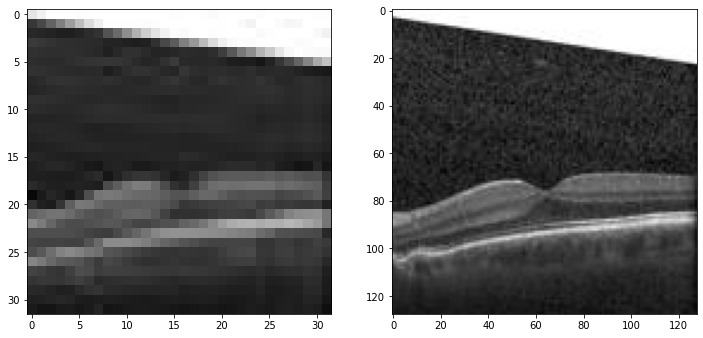

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

#cv2_imshow(np.reshape(lr_images[50], (32, 32, 3)))
#cv2_imshow(np.reshape(hr_images[50], (128, 128, 3)))

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.30, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)


In [ ]:
%cd /content/drive/MyDrive
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 5  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 150
#Enumerate training over epochs
for e in range(epochs):
    blockPrint()
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    enablePrint()

    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")
        print("Saveing a model")

/content/drive/MyDrive
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model_4 (Functional)           (None, 128, 128, 3)  2044291     ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_5 (Functional)           (None, 1)            38249281    ['mo

100%|██████████| 426/426 [01:12<00:00,  5.91it/s]


/content/drive/MyDrive
1/1 [==============================] - 1s 1s/step


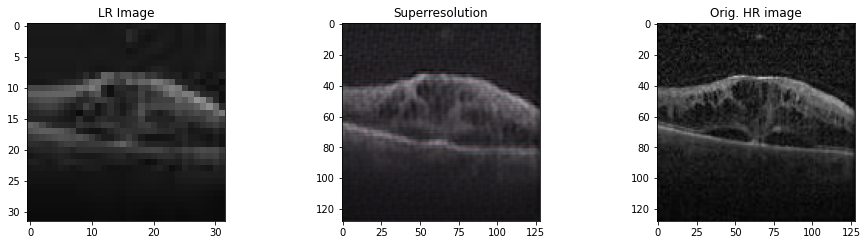

In [ ]:
%cd /content/drive/MyDrive
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_150.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix-1], X2[ix-1]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()



In [ ]:
from keras.models import load_model
import os

generator = load_model('gen_e_150.h5', compile=False)

import os
import numpy as np
from skimage import io

# define the path to the directory where the generated images will be saved
save_path = 'images1'

# create the directory if it doesn't already exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

# generate and save the images
for i in range(len(X1)):
    src_image, tar_image = X1[i:i+1], X2[i:i+1]
    gen_image = generator.predict(src_image)
    gen_image = np.clip(gen_image, 0, 1)  # clip the values to the valid range
    gen_image = np.uint8(gen_image * 255)  # scale the values to [0, 255] and convert to uint8
    io.imsave(os.path.join(save_path, f"img_{i+1}.jpg"), gen_image[0])

1/1 [==============================] - 0s 38ms/step


KeyboardInterrupt: ignored